In [163]:
#################################
#    SINGLE LAYER MODEL
#################################

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import pyrenn as prn

# Set whether the model should be trained on raw salary or logbase 10
use_log = True

# Set up dataframes for collecting overall error/performance
expt_accum_data = pd.DataFrame(columns=["Structure", "Avg Cum Error", "Avg Avg Error", "Avg % Error"])
train_accum_data = pd.DataFrame(columns=["Structure", "Avg Cum Error", "Avg Avg Error", "Avg % Error"])

# Set up training and test datasets in pyrenn-preferred format
df_train = pd.ExcelFile('RawData.xlsx').parse('Training_Data')
P = np.array([df_train['Minutes'].values,
              df_train['FG%'].values,
              df_train['3P%'].values,
              df_train['FT%'].values,
              df_train['REB'].values,
              df_train['AST'].values,
              df_train['STL'].values,
              df_train['BLK'].values,
              df_train['PF'].values,
              df_train['PPG'].values,
              df_train['Age'].values])

df_exp = pd.ExcelFile('RawData.xlsx').parse('Test_Data')
P_t = np.array([df_exp['Minutes'].values,
                df_exp['FG%'].values,
                df_exp['3P%'].values,
                df_exp['FT%'].values,
                df_exp['REB'].values,
                df_exp['AST'].values,
                df_exp['STL'].values,
                df_exp['BLK'].values,
                df_exp['PF'].values,
                df_exp['PPG'].values,
                df_exp['Age'].values])

# Use log() or whole salaries depending on parameter
if use_log: Y = df_train['log(Salary)'].values
else: Y = df_train['Salary'].values

if use_log: Y_truth = df_exp['log(Salary)']
else: Y_truth = df_exp['Salary']

# initialize in-loop statistic arrays
train_stats = np.zeros(3)
expt_stats = np.zeros(3)

# iterate through layer architectures and record performance of each over 3 trials
for i in range(3,22):
    print(f"Starting [11,{i},1]")
    for j in range(3):
        # Create NN with 1 hidden layer
        net = prn.CreateNN([11,i,1])
    
        # Prepare 
        data,net = prn.prepare_data(P,Y,net)
        
        #print("Training...")
        net = prn.train_LM(P, Y, net, k_max=1000, E_stop=0.000001, verbose=False) # set verbose to true to monitor iteration
        #print("Done Training :D")
        
        Y_control = abs(prn.NNOut(P,net))
        Y_out = abs(prn.NNOut(P_t,net))
        
        #print("########## CONTROL ##########")
        if use_log: err_arr = abs(10**Y_control - 10**Y)
        else: err_arr = abs(Y_control - Y)
        
        #print(f"Cumulative error over {len(err_arr)} values: {sum(err_arr)}\nWith average error {sum(err_arr)/len(err_arr)}")
        #print(f"Minimum val: {min(Y)}")

        train_stats = np.vstack([train_stats, [sum(err_arr), sum(err_arr)/len(err_arr), sum(abs(abs(10**Y_control - 10**Y)/10**Y_control))/len(err_arr)]])
        
        #print("########## EXPT #########")
        if use_log: err_arr = abs(10**Y_out - 10**Y_truth)
        else: err_arr = abs(Y_out - Y_truth)
        #print(f"Cumulative error over {len(err_arr)} values: {sum(err_arr)}\nWith average error {sum(err_arr)/len(err_arr)}")
        #print(f"Minimum val: {min(Y_out)}")

        expt_stats = np.vstack([train_stats, [sum(err_arr), sum(err_arr)/len(err_arr), sum(abs(abs(10**Y_truth - 10**Y_out)/10**Y_truth))/len(err_arr)]])

    # Add accumulated stats to dataframe for writing
    new_row = pd.DataFrame({"Structure" : f"[11,{i},1]", "Avg Cum Error" : [sum(train_stats[:,0])/3], "Avg Avg Error" : [sum(train_stats[:,1])/3], "Avg % Error" : [sum(train_stats[:,2])/3]})
    train_accum_data = pd.concat([train_accum_data, new_row])
    new_row = pd.DataFrame({"Structure" : f"[11,{i},1]", "Avg Cum Error" : [sum(expt_stats[:,0])/3], "Avg Avg Error" : [sum(expt_stats[:,1])/3], "Avg % Error" : [sum(expt_stats[:,2])/3]})
    expt_accum_data = pd.concat([expt_accum_data, new_row])

# Write out overall data for analysis
expt_accum_data.to_csv("Test_Error_Data_1L", sep=',')
train_accum_data.to_csv("Train_Error_Data_1L", sep=',')

    
'''fig, axs = plt.subplots(1,2)
x_ticks1 = range(len(Y_control))
x_ticks2 = range(len(Y_truth))
axs[0].plot(x_ticks1, Y, "ro", label="Guess")
axs[0].plot(x_ticks1, Y_control, "bx", label="Truth")
axs[0].title.set_text("Control (Training Set)")
axs[1].plot(x_ticks2, Y_truth, "ro", label="Guess")
axs[1].plot(x_ticks2, Y_out, "bx", label="Truth")
axs[1].title.set_text("Experimental (Test Set)")
plt.legend()'''

Starting [11,3,1]
Maximum number of iterations reached
Maximum number of iterations reached
Maximum number of iterations reached
Starting [11,4,1]


C:\Users\albus\AppData\Local\Temp\ipykernel_7472\3416236585.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_accum_data = pd.concat([train_accum_data, new_row])
C:\Users\albus\AppData\Local\Temp\ipykernel_7472\3416236585.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  expt_accum_data = pd.concat([expt_accum_data, new_row])


Maximum number of iterations reached
Maximum number of iterations reached


KeyboardInterrupt: 

In [94]:
##################################
#   TWO LAYER NETWORKS
##################################


import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import pyrenn as prn

# set up accumulating error data and whether the logbase 10 of the salary should be used
use_log = True
expt_accum_data = pd.DataFrame(columns=["Structure", "Avg Cum Error", "Avg Avg Error", "Avg % Error"])
train_accum_data = pd.DataFrame(columns=["Structure", "Avg Cum Error", "Avg Avg Error", "Avg % Error"])

# import training and testing data
df_train = pd.ExcelFile('RawData.xlsx').parse('Training_Data')
P = np.array([df_train['Minutes'].values,
              df_train['FG%'].values,
              df_train['3P%'].values,
              df_train['FT%'].values,
              df_train['REB'].values,
              df_train['AST'].values,
              df_train['STL'].values,
              df_train['BLK'].values,
              df_train['PF'].values,
              df_train['PPG'].values,
              df_train['Age'].values])

df_exp = pd.ExcelFile('RawData.xlsx').parse('Test_Data')
P_t = np.array([df_exp['Minutes'].values,
                df_exp['FG%'].values,
                df_exp['3P%'].values,
                df_exp['FT%'].values,
                df_exp['REB'].values,
                df_exp['AST'].values,
                df_exp['STL'].values,
                df_exp['BLK'].values,
                df_exp['PF'].values,
                df_exp['PPG'].values,
                df_exp['Age'].values])

# set up ground truth salary based on whether logbase 10 values should be used
if use_log: Y = df_train['log(Salary)'].values
else: Y = df_train['Salary'].values

if use_log: Y_truth = df_exp['log(Salary)']
else: Y_truth = df_exp['Salary']

# initialize stat arrays
train_stats = np.zeros(3)
expt_stats = np.zeros(3)

# exhaustively iterate through combinations of hidden layer architectures
for i in range(11,15):
    for j in range(5,15):
        print(f"Starting [11,{i},{j},1]")
        for k in range(3):
            # Create NN with 2 hidden layers
            net = prn.CreateNN([11,i,j,1])
        
            # Prepare 
            data,net = prn.prepare_data(P,Y,net)
            
            #print("Training...")
            net = prn.train_LM(P, Y, net, k_max=500, E_stop=0.000001, verbose=False) # set verbose to true to monitor iteration
            #print("Done Training :D")
            
            Y_control = abs(prn.NNOut(P,net))
            Y_out = abs(prn.NNOut(P_t,net))
            
            #print("########## CONTROL ##########")
            if use_log: err_arr = abs(10**Y_control - 10**Y)
            else: err_arr = abs(Y_control - Y)
            
            #print(f"Cumulative error over {len(err_arr)} values: {sum(err_arr)}\nWith average error {sum(err_arr)/len(err_arr)}")
            #print(f"Minimum val: {min(Y)}")
    
            train_stats = np.vstack([train_stats, [sum(err_arr), sum(err_arr)/len(err_arr), sum(abs(abs(10**Y_control - 10**Y)/10**Y_control))/len(err_arr)]])
            
            #print("########## EXPT #########")
            if use_log: err_arr = abs(10**Y_out - 10**Y_truth)
            else: err_arr = abs(Y_out - Y_truth)
            #print(f"Cumulative error over {len(err_arr)} values: {sum(err_arr)}\nWith average error {sum(err_arr)/len(err_arr)}")
            #print(f"Minimum val: {min(Y_out)}")
    
            expt_stats = np.vstack([train_stats, [sum(err_arr), sum(err_arr)/len(err_arr), sum(abs(abs(10**Y_truth - 10**Y_out)/10**Y_truth))/len(err_arr)]])
        # Add to accumulating stats
        new_row = pd.DataFrame({"Structure" : f"[11,{i},{j},1]", "Avg Cum Error" : [sum(train_stats[:,0])/3], "Avg Avg Error" : [sum(train_stats[:,1])/3], "Avg % Error" : [sum(train_stats[:,2])/3]})
        train_accum_data = pd.concat([train_accum_data, new_row])
        new_row = pd.DataFrame({"Structure" : f"[11,{i},{j},1]", "Avg Cum Error" : [sum(expt_stats[:,0])/3], "Avg Avg Error" : [sum(expt_stats[:,1])/3], "Avg % Error" : [sum(expt_stats[:,2])/3]})
        expt_accum_data = pd.concat([expt_accum_data, new_row])

# write out overall error for analysis
expt_accum_data.to_csv("Test_Error_Data_2L_b", sep=',')
train_accum_data.to_csv("Train_Error_Data_2L_b", sep=',')

    
'''fig, axs = plt.subplots(1,2)
x_ticks1 = range(len(Y_control))
x_ticks2 = range(len(Y_truth))
axs[0].plot(x_ticks1, Y, "ro", label="Guess")
axs[0].plot(x_ticks1, Y_control, "bx", label="Truth")
axs[0].title.set_text("Control (Training Set)")
axs[1].plot(x_ticks2, Y_truth, "ro", label="Guess")
axs[1].plot(x_ticks2, Y_out, "bx", label="Truth")
axs[1].title.set_text("Experimental (Test Set)")
plt.legend()'''

Starting [11,11,5,1]
Maximum number of iterations reached
Maximum number of iterations reached
Maximum number of iterations reached
Starting [11,11,6,1]


C:\Users\albus\AppData\Local\Temp\ipykernel_1360\1376776358.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_accum_data = pd.concat([train_accum_data, new_row])
C:\Users\albus\AppData\Local\Temp\ipykernel_1360\1376776358.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  expt_accum_data = pd.concat([expt_accum_data, new_row])


Maximum number of iterations reached
Maximum number of iterations reached
Maximum number of iterations reached
Starting [11,11,7,1]
Maximum number of iterations reached
Maximum number of iterations reached
Maximum number of iterations reached
Starting [11,11,8,1]
Maximum number of iterations reached
Maximum number of iterations reached
Maximum number of iterations reached
Starting [11,11,9,1]


KeyboardInterrupt: 

In [86]:
expt_accum_data.to_csv("Test_Error_Data_2L_b", sep=',')
train_accum_data.to_csv("Train_Error_Data_2L_b", sep=',')

Best architecture by error: [11,2,1]
Corresponding average error: $6170777.67


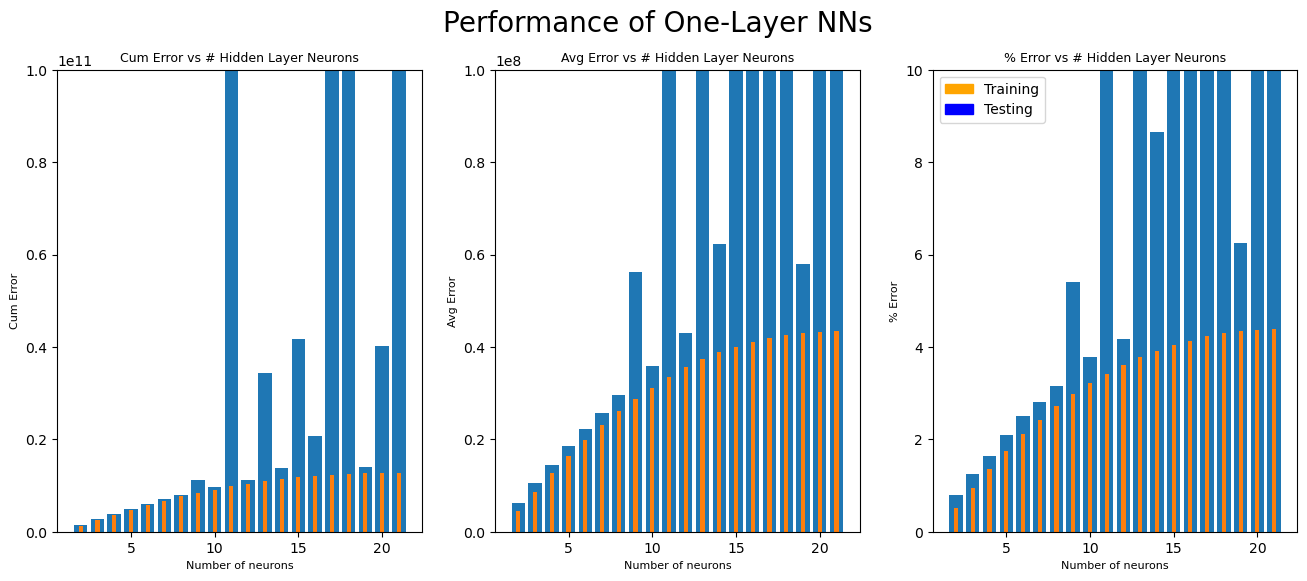

In [292]:
########################################
# PERFORMANCE OF SINGLE LAYER NNs
########################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.patches as mpatches

# Import benchmarking data
train_NNs = pd.read_csv("Train_Error_Data")
test_NNs = pd.read_csv("Test_Error_Data")

# Prepare x-axis ticks
raw_struct = test_NNs["Structure"]
structures = np.zeros(1)
for struct in raw_struct:
    structures = np.append(structures, int(literal_eval(struct)[1]))
structures = structures[1:]
x_ticks = range(int(structures[0]), int(structures[len(structures)-1])+1)

# Create figure with 3 subplots and axis handles
fig2, axs2 = plt.subplots(1,3, figsize=(16, 6))
fig2.suptitle("Performance of One-Layer NNs",fontsize=20)

# Plot error metrics on the three subplots
axs2[0].bar(x_ticks, test_NNs["Avg Cum Error"], label="Test")
axs2[0].bar(x_ticks, train_NNs["Avg Cum Error"],width=0.25, label="Train")
axs2[0].set_title("Cum Error vs # Hidden Layer Neurons", fontsize=9)
axs2[0].set_ylim([0, 100000000000])
axs2[0].set_xlabel("Number of neurons", fontsize=8)
axs2[0].set_ylabel("Cum Error", fontsize=8)

axs2[1].bar(x_ticks, test_NNs["Avg Avg Error"])
axs2[1].bar(x_ticks, train_NNs["Avg Avg Error"],width=0.25, label="Train")
axs2[1].set_title("Avg Error vs # Hidden Layer Neurons", fontsize=9)
axs2[1].set_ylim([0, 100000000])
axs2[1].set_xlabel("Number of neurons", fontsize=8)
axs2[1].set_ylabel("Avg Error", fontsize=8)

axs2[2].bar(x_ticks, test_NNs["Avg % Error"])
axs2[2].bar(x_ticks, train_NNs["Avg % Error"],width=0.25, label="Train")
axs2[2].set_title("% Error vs # Hidden Layer Neurons", fontsize=9)
axs2[2].set_ylim([0, 10])
axs2[2].set_xlabel("Number of neurons", fontsize=8)
axs2[2].set_ylabel("% Error", fontsize=8)

# create legend
orange_patch = mpatches.Patch(color='orange', label='Training')
blue_patch = mpatches.Patch(color='blue', label='Testing')
plt.legend(handles=[orange_patch, blue_patch], loc=2)

best_avg = np.where(test_NNs["Avg Avg Error"] == min(test_NNs["Avg Avg Error"]))[0][0]
print(f"Best architecture by error: [11,{int(structures[best_avg])},1]")
print(f"Corresponding average error: ${round(test_NNs["Avg Avg Error"][best_avg],2)}")

Best architecture by error: [11,9,5,1]
Corresponding training average error: $1791883.19
Corresponding test average error: $5812703.43


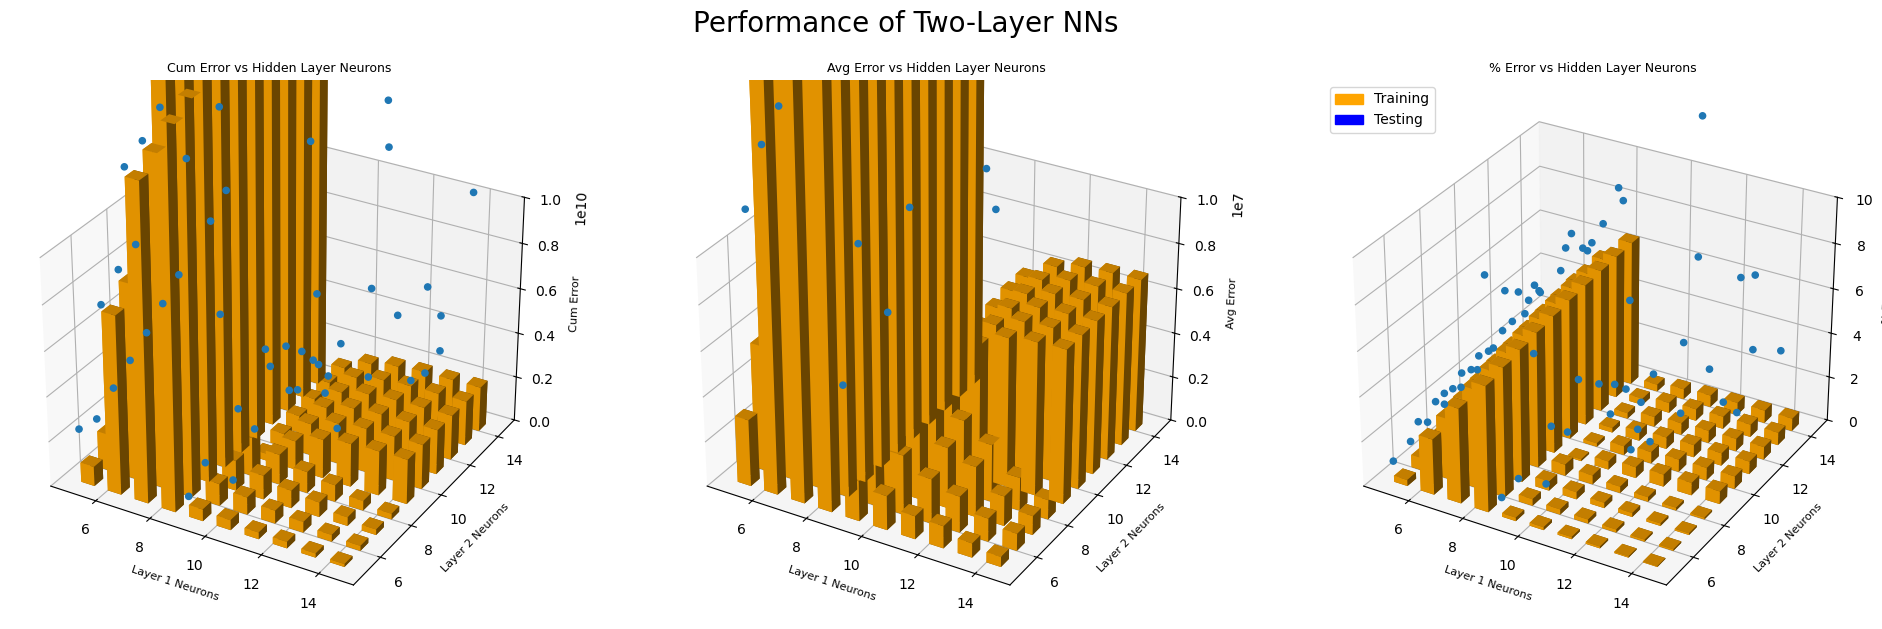

In [300]:
########################################
# PERFORMANCE OF TWO LAYER NNs
########################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.patches as mpatches

# Import benchmarking data
train_NNs = pd.read_csv("Train_Error_Data_2L_a")
test_NNs = pd.read_csv("Test_Error_Data_2L_a")

# Create 2D coordinate grid for plotting
raw_struct = train_NNs["Structure"]
structures = np.zeros(2)
for struct in raw_struct:
    structures = np.vstack([structures, literal_eval(struct)[1:3]])
structures = structures[1:]


#xrange = range(int(min(structures[:,0])), int(max(structures[:,0]))+1)
#yrange = range(int(min(structures[:,1])), int(max(structures[:,1]))+1)
#cum_error = test_NNs["Avg Cum Error"]
#print(cum_error.shape)
#cum_error = np.split(cum_error, 10)

# Create figure with 3 subplots and axis handles
fig = plt.figure(figsize=(24,7))
fig.suptitle("Performance of Two-Layer NNs",fontsize=20)

# Plot error metrics on the three subplots
axs2[0] = fig.add_subplot(1,3,1,projection='3d')
axs2[0].bar3d(structures[:,0], structures[:,1], np.zeros(100), 0.5, 0.5, train_NNs["Avg Cum Error"], label="Train", color='orange')
axs2[0].scatter(structures[:,0], structures[:,1],test_NNs["Avg Cum Error"],label="Test", alpha=1.0)
axs2[0].set_title("Cum Error vs Hidden Layer Neurons", fontsize=9)
axs2[0].set_zlim([0, 1e10])
axs2[0].set_xlabel("Layer 1 Neurons", fontsize=8)
axs2[0].set_ylabel("Layer 2 Neurons", fontsize=8)
axs2[0].set_zlabel("Cum Error", fontsize=8)

axs2[1] = fig.add_subplot(1,3,2,projection='3d')
axs2[1].bar3d(structures[:,0], structures[:,1], np.zeros(100), 0.5, 0.5, train_NNs["Avg Avg Error"], label="Train", color='orange')
axs2[1].scatter(structures[:,0], structures[:,1],test_NNs["Avg Avg Error"],label="Test", alpha=1.0)
axs2[1].set_title("Avg Error vs Hidden Layer Neurons", fontsize=9)
axs2[1].set_zlim([0, 1e7])
axs2[1].set_xlabel("Layer 1 Neurons", fontsize=8)
axs2[1].set_ylabel("Layer 2 Neurons", fontsize=8)
axs2[1].set_zlabel("Avg Error", fontsize=8)

axs2[2] = fig.add_subplot(1,3,3,projection='3d')
axs2[2].bar3d(structures[:,0], structures[:,1], np.zeros(100), 0.5, 0.5, train_NNs["Avg % Error"], label="Train", color='orange')
axs2[2].scatter(structures[:,0], structures[:,1],test_NNs["Avg % Error"],label="Test", alpha=1.0)
axs2[2].set_title("% Error vs Hidden Layer Neurons", fontsize=9)
axs2[2].set_zlim([0, 10])
axs2[2].set_xlabel("Layer 1 Neurons", fontsize=8)
axs2[2].set_ylabel("Layer 2 Neurons", fontsize=8)
axs2[2].set_zlabel("% Error", fontsize=8)

# create legend
orange_patch = mpatches.Patch(color='orange', label='Training')
blue_patch = mpatches.Patch(color='blue', label='Testing')
plt.legend(handles=[orange_patch, blue_patch], loc=2)

best_avg = np.where(test_NNs["Avg Avg Error"] == min(test_NNs["Avg Avg Error"]))[0][0]
print(f"Best architecture by error: [11,{int(structures[best_avg,0])},{int(structures[best_avg,1])},1]")
print(f"Corresponding training average error: ${round(train_NNs["Avg Avg Error"][best_avg],2)}")
print(f"Corresponding test average error: ${round(test_NNs["Avg Avg Error"][best_avg],2)}")

In [354]:
########################################
# OPTIMAL MODEL ARCHITECTURE TRAINING
########################################

df_train = pd.ExcelFile('RawData.xlsx').parse('Training_Data')
P = np.array([df_train['Minutes'].values,
              df_train['FG%'].values,
              df_train['3P%'].values,
              df_train['FT%'].values,
              df_train['REB'].values,
              df_train['AST'].values,
              df_train['STL'].values,
              df_train['BLK'].values,
              df_train['PF'].values,
              df_train['PPG'].values,
              df_train['Age'].values])

df_exp = pd.ExcelFile('RawData.xlsx').parse('Test_Data')
P_t = np.array([df_exp['Minutes'].values,
                df_exp['FG%'].values,
                df_exp['3P%'].values,
                df_exp['FT%'].values,
                df_exp['REB'].values,
                df_exp['AST'].values,
                df_exp['STL'].values,
                df_exp['BLK'].values,
                df_exp['PF'].values,
                df_exp['PPG'].values,
                df_exp['Age'].values])

if use_log: Y = df_train['log(Salary)'].values
else: Y = df_train['Salary'].values

if use_log: Y_truth = df_exp['log(Salary)']
else: Y_truth = df_exp['Salary']

net = prn.CreateNN([11,9,5,1])
data,net = prn.prepare_data(P,Y,net)
net = prn.train_LM(P, Y, net, k_max=500, E_stop=0.000001, verbose=False) # set verbose to true to monitor iteration


Maximum number of iterations reached


In [356]:
########################################
# BRONNY PREDICTION
########################################

Bronny = np.array([2.6, 16.7, 0.0, 100, 0.2, 0.3, 0.2, 0.0, 0.3, 6, 20])
Bronny = np.vstack([Bronny, np.zeros(11)])
Bronny = np.transpose(Bronny)

guess = abs(prn.NNOut(Bronny,net))[0]
print(10**guess)

1474347.2014993697
